In [28]:
import os

In [29]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualization and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# configures matplotlib to inline and will display graphs below the corresponding cell
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess
from keras.preprocessing.image import ImageDataGenerator

#libraries
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

#for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

#manipulation of zipped images and getting numpy arrays of pixel values of images
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

In [30]:
X = []
Z = []
IMG_SIZE = 150
BEE_BLUEBERRY_DIR = '../bees/blueberrybees'
BEE_BUMBLE_DIR = '../bees/bumblebees'
BEE_CARPENTER_DIR = '../bees/carpenterbees'
BEE_HONEY_DIR = '../bees/honeybees'
BEE_MASON_DIR = '../bees/masonbees'
BEE_MINING_DIR = '../bees/miningbees'
BEE_WESTERNHONEY_DIR = '../bees/westernhoneybees'

In [31]:
def assign_label(img,bee_type):
    return bee_type

In [32]:
def make_train_data(bee_type, DIR):
    for img in tqdm(os.listdir(DIR)):
        label = assign_label(img, bee_type)
        path = os.path.join(DIR, img)
        ext = img[-4:]
        if (ext != '.jpg'):
            continue
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [33]:
make_train_data('Blueberry Bee', BEE_BLUEBERRY_DIR)
print(len(X))

100%|██████████| 1201/1201 [00:05<00:00, 231.17it/s]

785


In [34]:
make_train_data('Bumblebee', BEE_BUMBLE_DIR)
print(len(X))

100%|██████████| 707/707 [00:03<00:00, 191.73it/s]

1451


In [35]:
make_train_data('Carpenter Bee', BEE_CARPENTER_DIR)
print(len(X))

100%|██████████| 612/612 [00:02<00:00, 229.41it/s]

2025


In [36]:
make_train_data('Honey Bee', BEE_HONEY_DIR)
print(len(X))

100%|██████████| 634/634 [00:03<00:00, 170.37it/s]

2621


In [37]:
make_train_data('Mason Bee', BEE_MASON_DIR)
print(len(X))

100%|██████████| 1737/1737 [00:05<00:00, 304.12it/s]

3760


In [38]:
make_train_data('Mining Bee', BEE_MINING_DIR)
print(len(X))

100%|██████████| 1421/1421 [00:04<00:00, 311.60it/s]

4710


In [39]:
make_train_data('Western Honey Bees', BEE_WESTERNHONEY_DIR)
print(len(X))

100%|██████████| 2016/2016 [00:06<00:00, 324.85it/s]

5929


In [40]:
# Gaussian Blur
# def blur():
#     for i in range(1, len(X)):
#         X[i] = cv2.GaussianBlur(X[i], (5, 5), 0) 

# Preprocessing
for i in range(len(X)):
    # Gaussian Blur
    im = X[i]
    im = cv2.GaussianBlur(im, (5, 5), 0)
    X[i] = im
    
# Not using the preprocessing below because they don't mark the bees very well
#     # Image Segmentation
#     gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
#     ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
#     # Further noise removal
#     kernel = np.ones((3, 3), np.uint8)
#     opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
#     # sure background area
#     sure_bg = cv2.dilate(opening, kernel, iterations=3)
#     # Finding sure foreground area
#     dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
#     ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
#     # Finding unknown region
#     sure_fg = np.uint8(sure_fg)
#     unknown = cv2.subtract(sure_bg, sure_fg)

#     # Marker labelling
#     ret, markers = cv2.connectedComponents(sure_fg)
#     # Add one to all labels so that sure background is not 0, but 1
#     markers = markers + 1
#     # Now, mark the region of unknown with zero
#     markers[unknown == 255] = 0
    
#     markers = cv2.watershed(im, markers)
#     im[markers == -1] = [255, 0, 0]
#     markers = cv2.watershed(X[i], markers)
#     X[i] = im

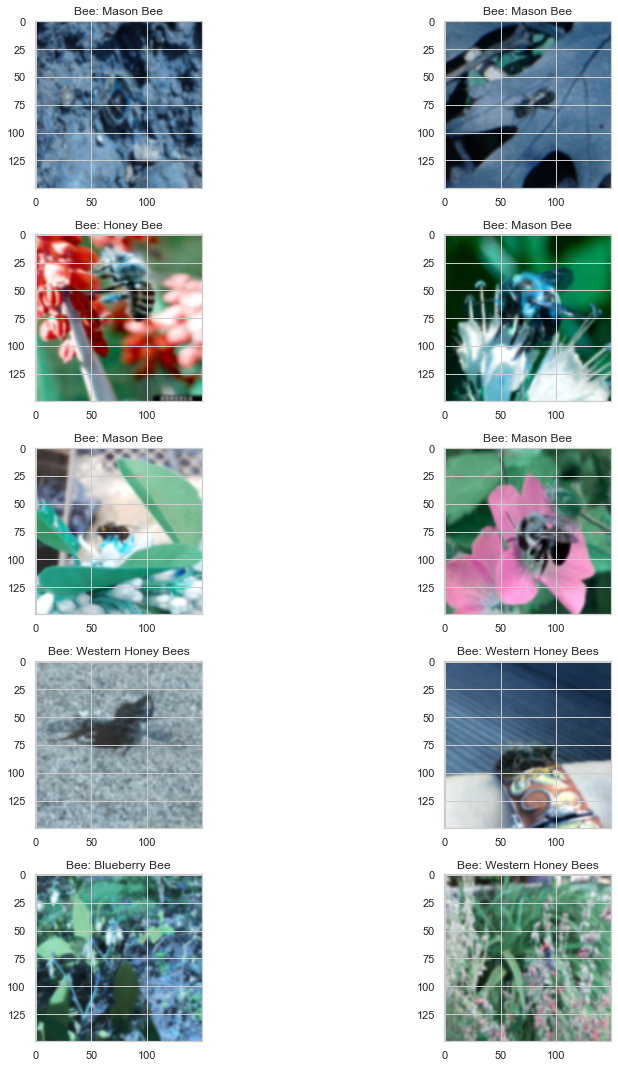

In [41]:
#visualize 10 random images with blurring preprocessing
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(2):
        l=rn.randint(0,len(Z))
        ax[i, j].imshow(X[l])
        ax[i,j].set_title('Bee: '+Z[l])
plt.tight_layout()

In [42]:
# label encoding
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,7)
X=np.array(X)
X=X/255

In [43]:
#splitting into training and validation sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)

In [44]:
#inputting the random seeds
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [45]:
# Using CNN to start modelling

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

# model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Activation('relu'))
model.add(Dense(7, activation = "softmax"))

In [46]:
# Using a LR Annealer

batch_size=128
epochs=100

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [47]:
# data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [48]:
# compiling the model & summary
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 37, 37, 64)       

In [49]:
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage

In [50]:
# fitting training set and making predictions on the validation set
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/100
34/34 [==============================] - 94s 3s/step - loss: 2.2113 - accuracy: 0.2286 - val_loss: 1.8732 - val_accuracy: 0.2347
Epoch 2/100
34/34 [==============================] - 85s 2s/step - loss: 1.8891 - accuracy: 0.2538 - val_loss: 1.8715 - val_accuracy: 0.2198
Epoch 3/100
34/34 [==============================] - 88s 3s/step - loss: 1.8421 - accuracy: 0.2781 - val_loss: 1.8895 - val_accuracy: 0.2104
Epoch 4/100
34/34 [==============================] - 86s 3s/step - loss: 1.7928 - accuracy: 0.3052 - val_loss: 1.9121 - val_accuracy: 0.1888
Epoch 5/100
34/34 [==============================] - 83s 2s/step - loss: 1.7239 - accuracy: 0.3374 - val_loss: 1.8764 - val_accuracy: 0.2367
Epoch 6/100
34/34 [==============================] - 86s 3s/step - loss: 1.6852 - accuracy: 0.3520 - val_loss: 1.8906 - val_accuracy: 0.1989
Epoch 7/100
34/34 [==============================] - 84s 2s/step - loss: 1.6386 - accuracy: 0.3705 - val_loss: 1.8784 - val_accuracy: 0.2488
Epoch 8/100
3

Epoch 59/100
34/34 [==============================] - 91s 3s/step - loss: 0.7661 - accuracy: 0.7378 - val_loss: 1.0737 - val_accuracy: 0.6318
Epoch 60/100
34/34 [==============================] - 89s 3s/step - loss: 0.7752 - accuracy: 0.7314 - val_loss: 1.0301 - val_accuracy: 0.6521
Epoch 61/100
34/34 [==============================] - 82s 2s/step - loss: 0.7561 - accuracy: 0.7334 - val_loss: 1.0120 - val_accuracy: 0.6534
Epoch 62/100
34/34 [==============================] - 82s 2s/step - loss: 0.7296 - accuracy: 0.7520 - val_loss: 1.1140 - val_accuracy: 0.6150
Epoch 63/100
34/34 [==============================] - 91s 3s/step - loss: 0.7415 - accuracy: 0.7378 - val_loss: 1.0341 - val_accuracy: 0.6460
Epoch 64/100
34/34 [==============================] - 85s 3s/step - loss: 0.7258 - accuracy: 0.7470 - val_loss: 1.0083 - val_accuracy: 0.6487
Epoch 65/100
34/34 [==============================] - 86s 3s/step - loss: 0.7260 - accuracy: 0.7415 - val_loss: 0.9940 - val_accuracy: 0.6622
Epoch 

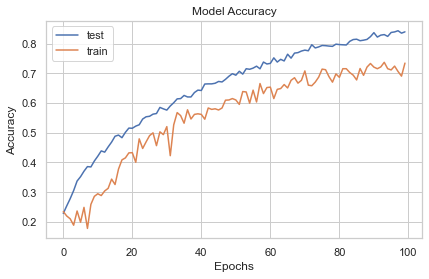

In [51]:
# graph for model accuracy between training and validation
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['test', 'train'])
plt.show()

In [54]:
# print(x_test)
predictions = model.predict(x_test)
# print(predictions)
# print(predictions[0])

In [55]:
class_names = ['Blueberry Bee', 'Bumblebee', 'Carpenter Bee', 'Honey Bee',
               'Mason Bee', 'Mining Bee', 'Western Honey Bee']

def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(7))
  plt.yticks([])
  thisplot = plt.bar(range(7), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

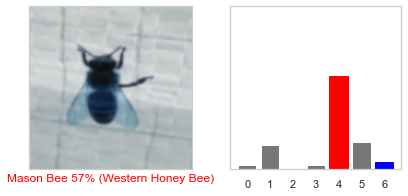

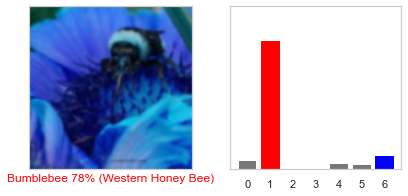

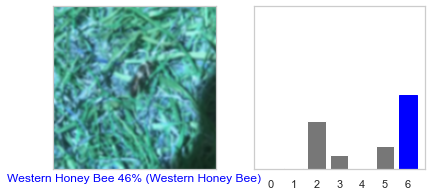

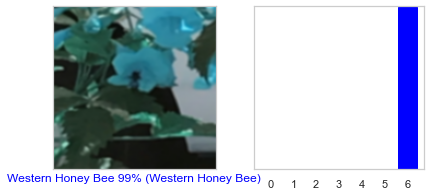

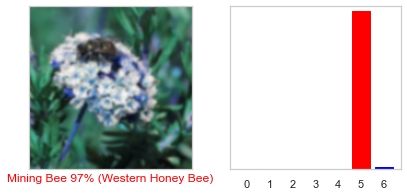

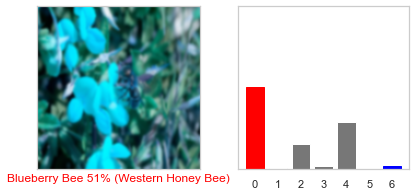

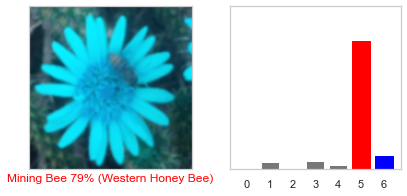

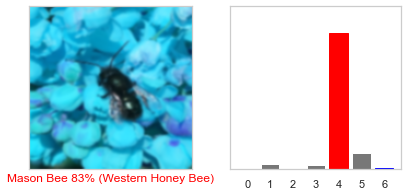

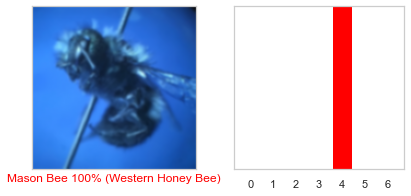

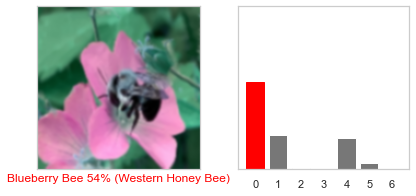

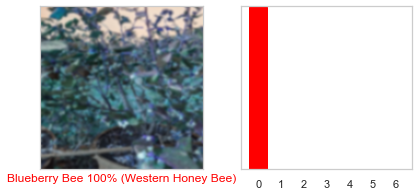

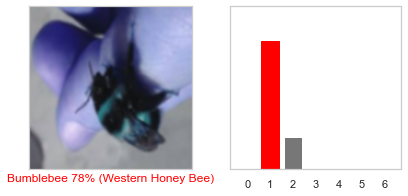

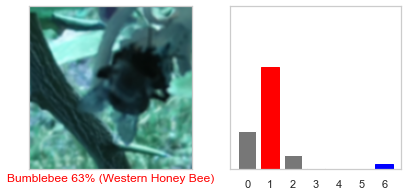

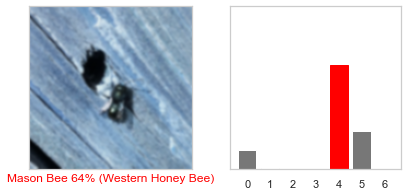

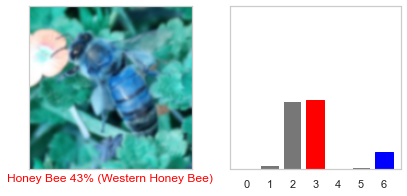

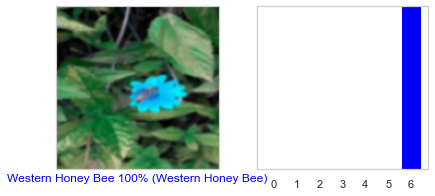

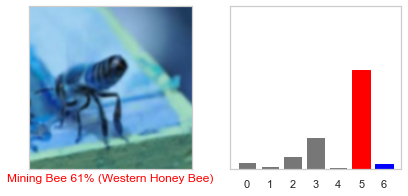

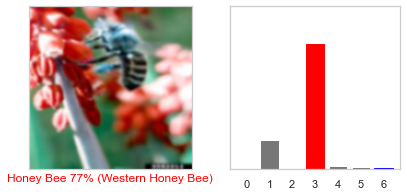

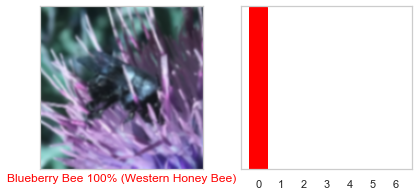

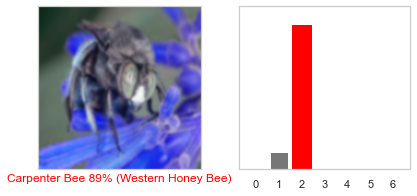

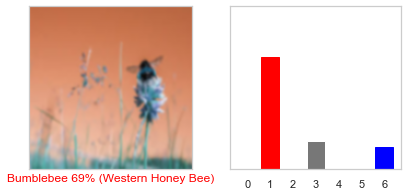

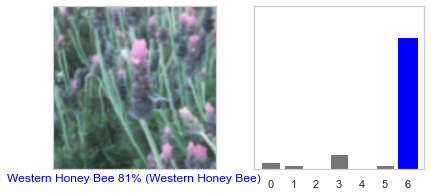

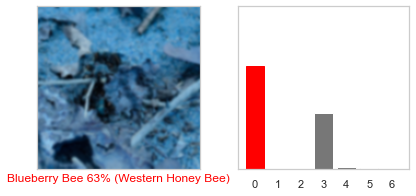

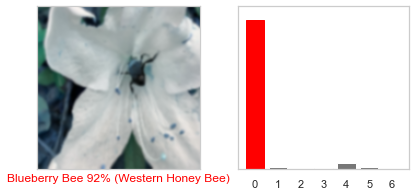

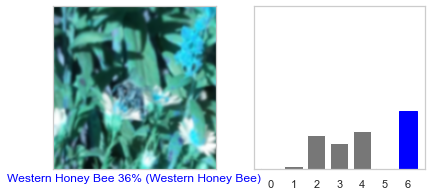

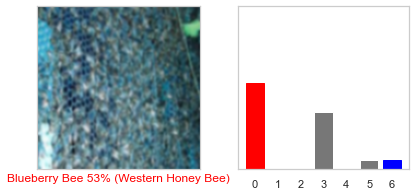

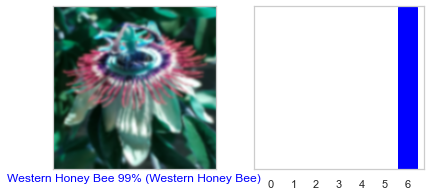

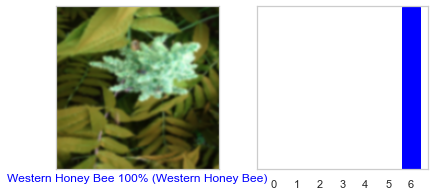

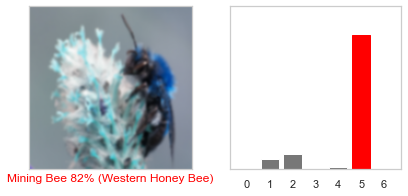

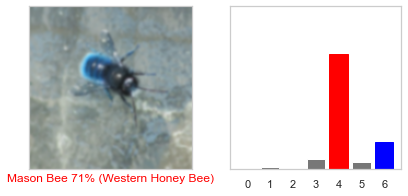

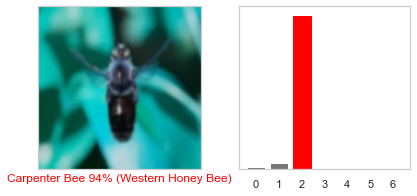

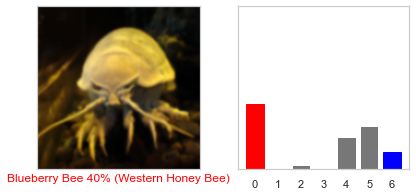

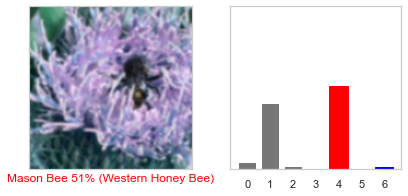

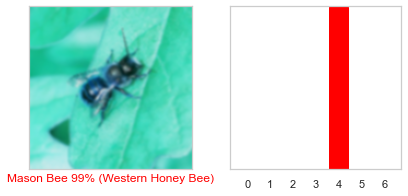

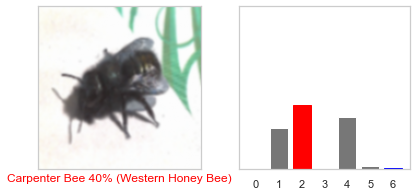

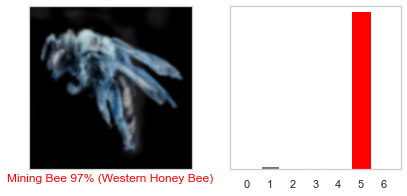

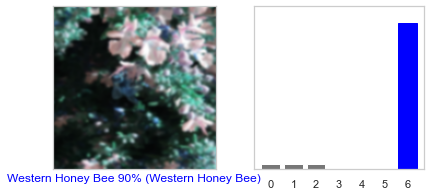

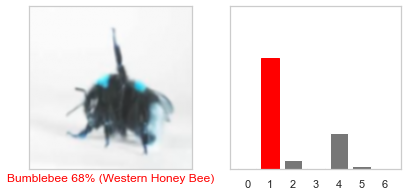

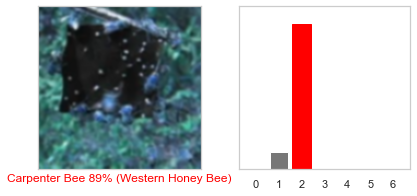

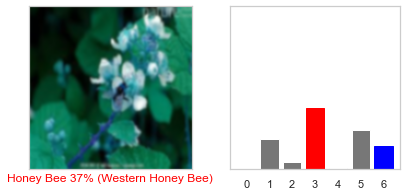

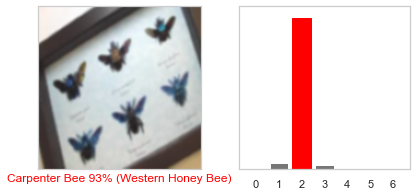

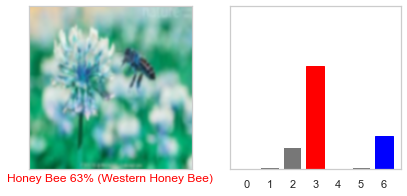

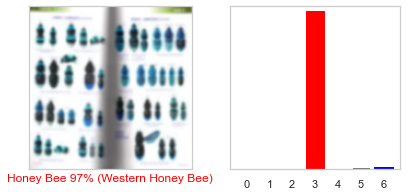

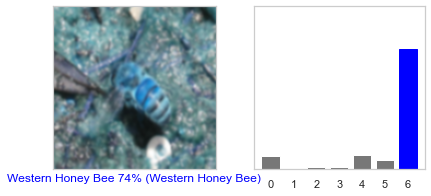

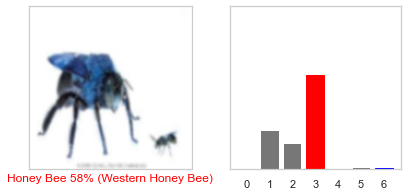

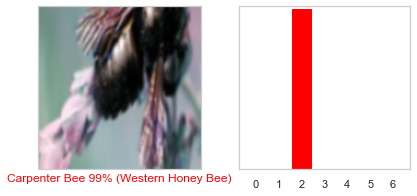

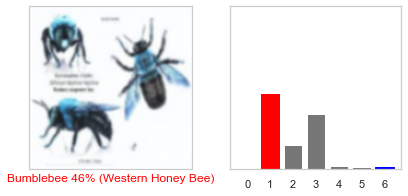

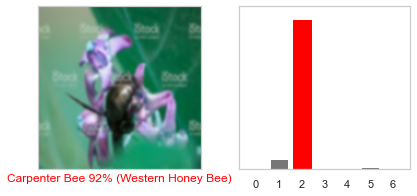

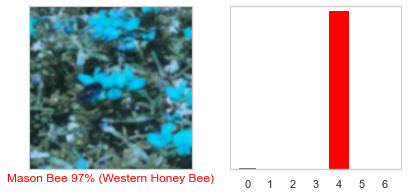

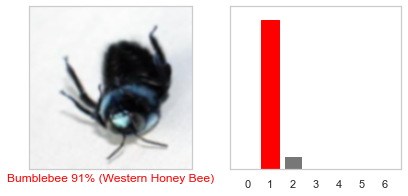

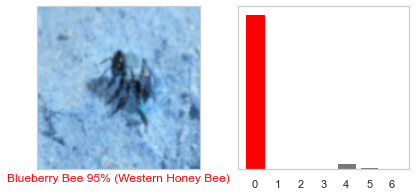

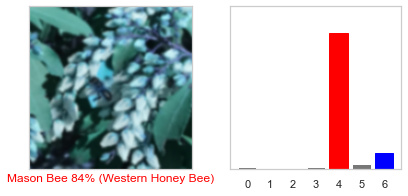

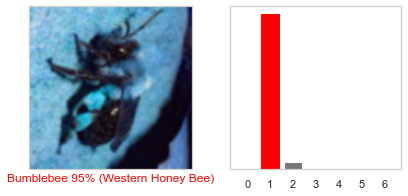

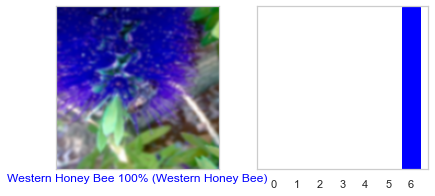

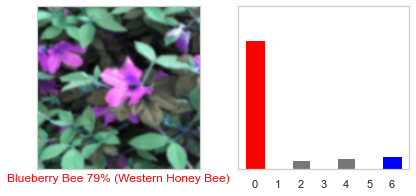

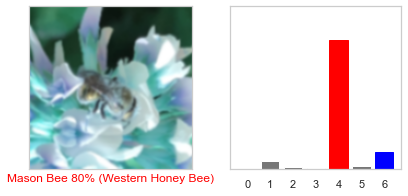

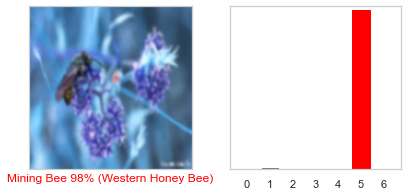

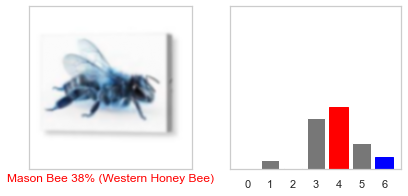

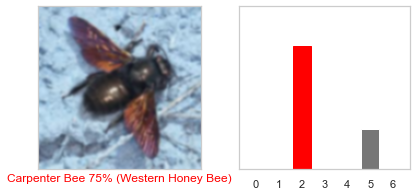

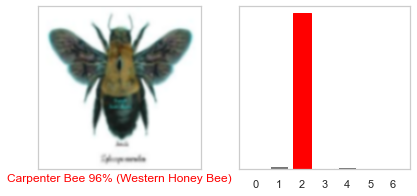

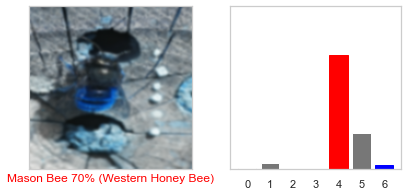

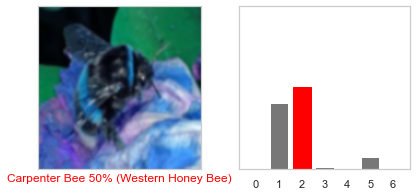

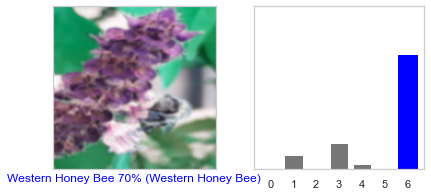

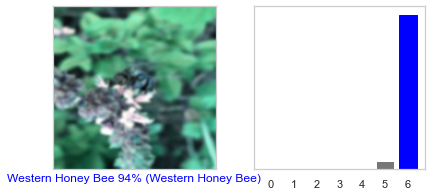

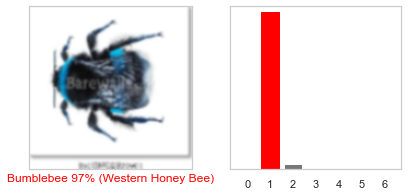

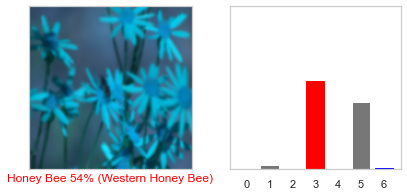

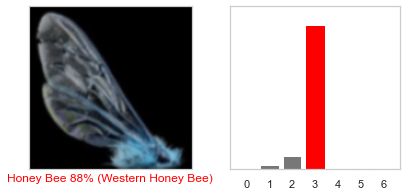

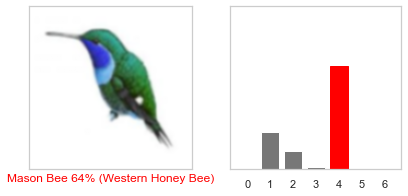

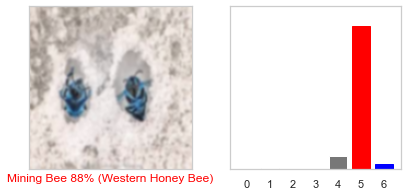

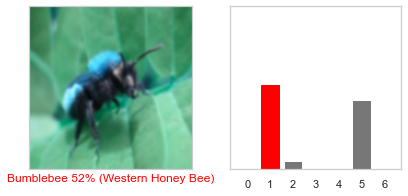

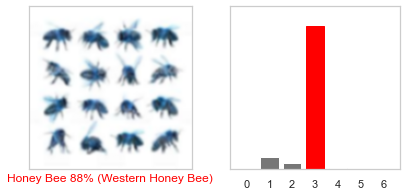

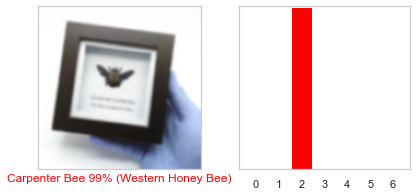

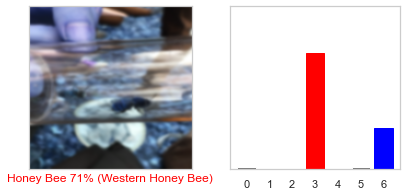

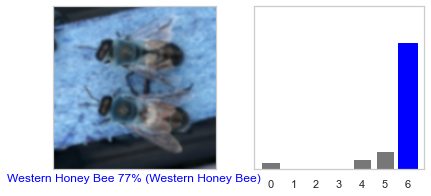

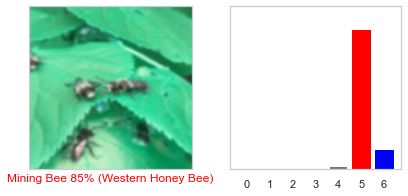

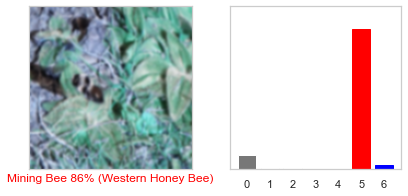

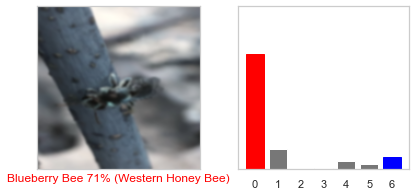

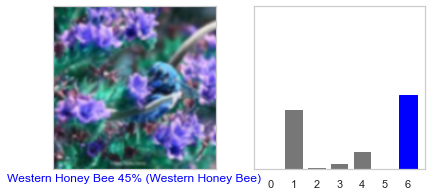

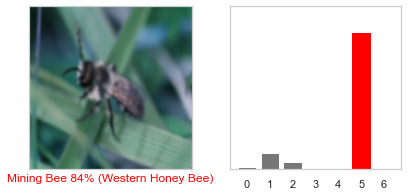

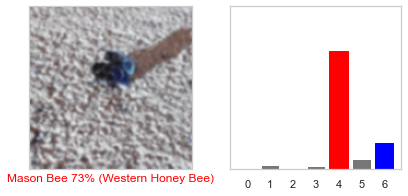

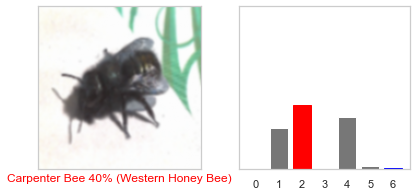

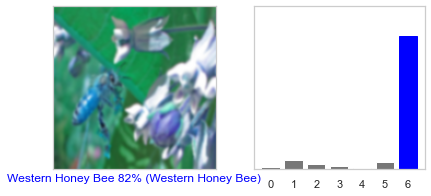

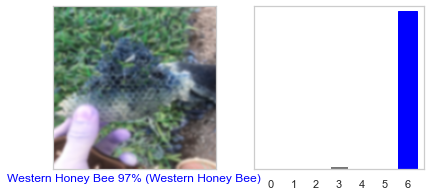

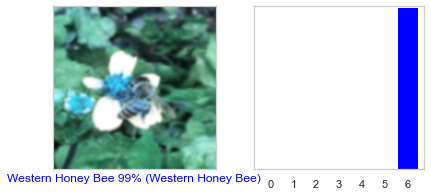

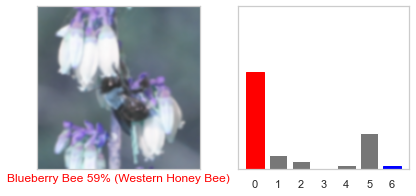

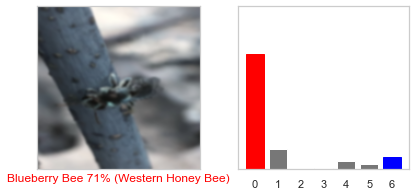

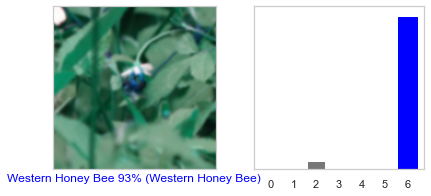

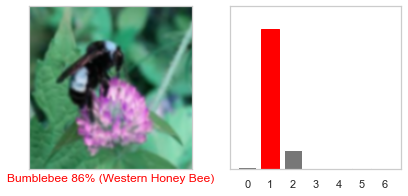

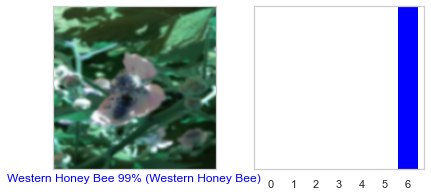

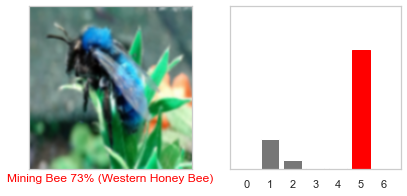

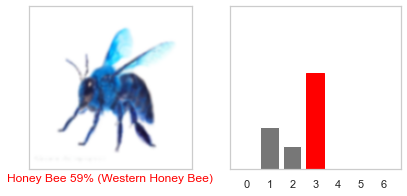

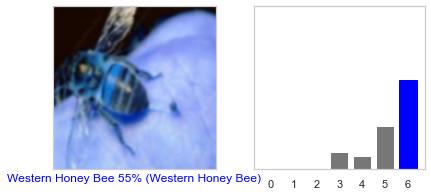

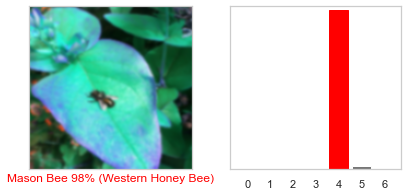

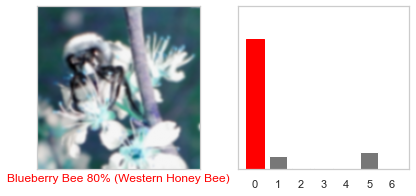

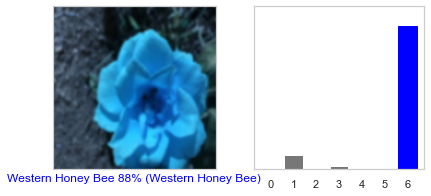

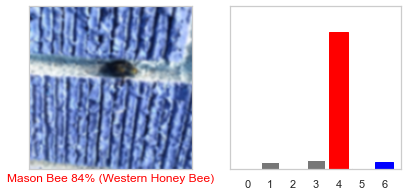

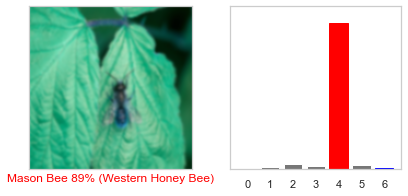

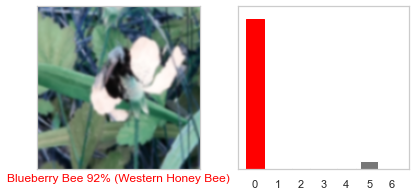

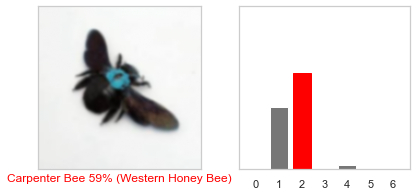

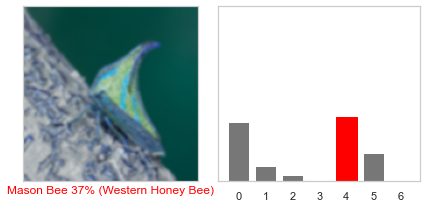

In [56]:
y_ = [np.argmax(y_test, axis=None, out=None) for y in y_test]
for i in range(100):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(i, predictions[i], y_, x_test)
    plt.subplot(1,2,2)
    plot_value_array(i, predictions[i], y_)
    #plt.show()
plt.tight_layout()

In [57]:
# export bee model
model_path = "../bee_model_v1"
model.save(model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../bee_model_v1/assets


In [58]:
# load bee model
from tensorflow import keras
loaded_model = keras.models.load_model(model_path)

In [59]:
# verify that the exported model works properly
prediction_by_model = model.predict(x_test)
prediction_by_loaded_model = loaded_model.predict(x_test)

In [60]:
print(prediction_by_model[0])
print(prediction_by_loaded_model[0])

[0.0294068  0.14743412 0.00901482 0.02542292 0.57345176 0.16891932
 0.0463502 ]
[0.0294068  0.14743412 0.00901482 0.02542292 0.57345176 0.16891932
 0.0463502 ]


In [61]:
from tensorflow.keras.preprocessing.image import img_to_array
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

def classify(img_path, saved_model, class_names):
    # Preprocess image
    IMG_SIZE = 150
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = img.astype("float") / 255.0
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    
    prediction = saved_model.predict(img_batch)
    # print(prediction)
    print(class_names[np.argmax(prediction)] + '(' + str(round(100*np.max(prediction), 2)) + '%)')

In [62]:
class_names = ['Blueberry Bee', 'Bumblebee', 'Carpenter Bee', 'Honey Bee',
               'Mason Bee', 'Mining Bee', 'Western Honey Bee']

In [65]:
classify('../test_images/honeybee_1.jpg', loaded_model, class_names)

Honey Bee(98.7%)


In [66]:
classify('../test_images/carpenter_bee_1.jpg', loaded_model, class_names)

Mining Bee(50.03%)


In [67]:
classify('../test_images/western_honey_bee_1.jpg', loaded_model, class_names)

Honey Bee(61.53%)


In [68]:
classify('../test_images/mason_bee_1.jpg', loaded_model, class_names)

Honey Bee(65.86%)


In [69]:
classify('../test_images/bumble_bee_2.jpg', loaded_model, class_names)

Mining Bee(61.73%)


In [70]:
classify('../test_images/blueberry_bee_2.jpg', loaded_model, class_names)

Carpenter Bee(99.98%)


In [71]:
classify('../test_images/mason_bee_2.jpg', loaded_model, class_names)

Carpenter Bee(92.34%)


In [72]:
classify('../test_images/western_honey_bee_1.jpg', loaded_model, class_names)

Honey Bee(61.53%)


In [73]:
classify('../test_images/carpenter_bee_1.jpg', loaded_model, class_names)

Mining Bee(50.03%)
